In [2]:
import numpy as np

from definitions import *
from trainTestValSplit import getTrainTestValSplit
from preProcessing import preProcess

from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
train_concat, test_concat, val_concat = getTrainTestValSplit(
    _dataset_path=f'{ROOT_DIR}/dataset/ExtraSensory/Processed'
)

In [3]:
train_x, train_y = preProcess(train_concat)
test_x, test_y = preProcess(test_concat)
val_x, val_y = preProcess(val_concat)

columns = train_x.columns
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)
val_x = val_x.fillna(0)

n_columns = len(columns)
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()
val_x = val_x.to_numpy()
val_y = val_y.to_numpy()
#
# from sklearn.decomposition import PCA
# pca = PCA(n_components=50)
#
# train_x = pca.fit_transform(train_x, train_y)
# test_x = pca.fit_transform(test_x, test_y)
# val_x = pca.fit_transform(val_x, val_y)

In [4]:
n_features: int = n_columns

In [5]:
train_y = encodeTarget(train_y)
test_y = encodeTarget(test_y)
val_y = encodeTarget(val_y)

In [6]:
train_x = reshape_and_truncate(train_x, (-1, window_size, n_features))
train_y = reshape_and_truncate(train_y, (-1, window_size, len(main_activity_label_classes)))

test_x = reshape_and_truncate(test_x, (-1, window_size, n_features))
test_y = reshape_and_truncate(test_y, (-1, window_size, len(main_activity_label_classes)))

val_x = reshape_and_truncate(val_x, (-1, window_size, n_features))
val_y = reshape_and_truncate(val_y, (-1, window_size, len(main_activity_label_classes)))

In [7]:
with tf.device('/cpu:0'):
    model = tf.keras.Sequential()

    layer = tf.keras.layers.Normalization(axis=-1)
    layer.adapt(train_x)
    model.add(layer)
    model.add(tf.keras.layers.LSTM(100, return_sequences=True, activation='tanh'))
    model.add(tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(n_y, activation=tf.keras.activations.softmax))

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=
    tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
    ), metrics=['acc'])
    history = model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=epochs, batch_size=batch_size,
                        callbacks=[
                            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience,
                                                             mode='auto', restore_best_weights=True)])
    predict = model.predict(test_x)


KeyboardInterrupt



In [3]:
gold_labels = np.load('gold.txt.npy')
predicted_labels = np.load('pred.txt.npy')

In [9]:
print(f'F1: {f1_score(gold_labels, predicted_labels, average="weighted")}')
print(f'Precision: {precision_score(gold_labels, predicted_labels, average="weighted", zero_division=0)}')
print(f'Recall: {recall_score(gold_labels, predicted_labels, average="weighted", zero_division=0)}')

F1: 0.7194378128247972
Precision: 0.7297577589852757
Recall: 0.7639004149377593


In [10]:
tf.math.confusion_matrix(gold_labels, predicted_labels)

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[1158,    5,   35,    8,    0,    0,    0],
       [   5, 1789,  293,   16,    3,    0,    0],
       [  15,   65, 2384,   22,   24,    0,    1],
       [   5,   92,  732,   60,   41,    0,   17],
       [   4,    5,  113,   34,  130,    0,    5],
       [   0,    6,    5,    0,    0,    0,    0],
       [  18,   10,  105,    8,   15,    0,    2]])>

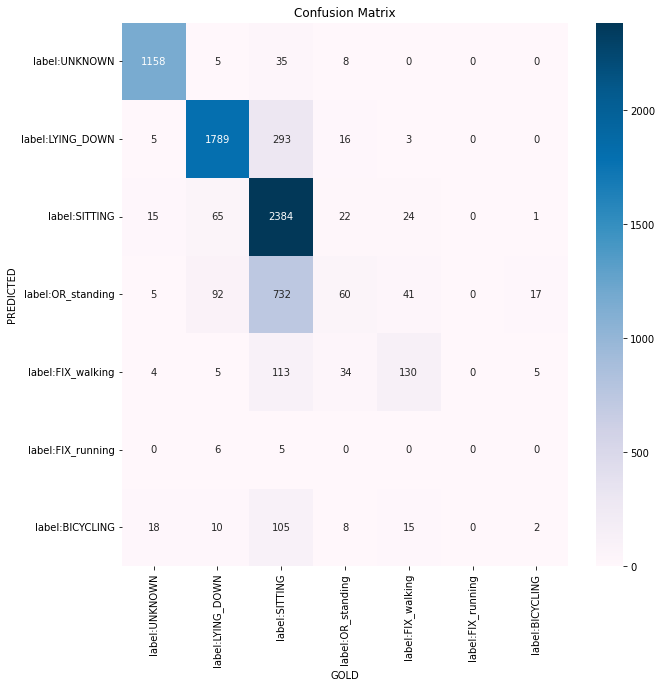

In [4]:
plot_conf_matrix(gold_labels, predicted_labels)

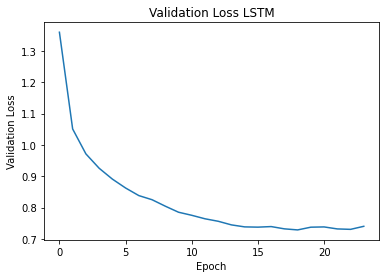

In [12]:
plot_val_loss_progress(history)

array([[ 1.39961285e+02,  6.87577886e+02,  2.12362849e+02, ...,
         3.52129190e+00, -2.52147204e+00, -2.29142961e+00],
       [ 1.84086525e+02,  8.99400953e+02, -5.65524557e+02, ...,
        -6.66557860e-02,  3.58604191e+00, -2.12955261e+00],
       [ 1.81524255e+02,  8.92424449e+02, -5.59237995e+02, ...,
         2.49800945e-01,  1.06418966e+01,  8.43332293e+00],
       ...,
       [-1.73323535e+03, -2.35332495e+02, -1.87871073e+01, ...,
         2.76242688e-01,  1.91736721e-01,  1.13289525e-01],
       [-1.73376653e+03, -2.32727794e+02, -1.80871742e+01, ...,
         2.05901100e-01,  2.09933389e-01,  2.73065701e-02],
       [-1.72954144e+03, -2.56966514e+02, -2.34026500e+01, ...,
        -1.05731433e+01,  4.23683080e-01,  4.77078222e-01]])